In [2]:
import keras
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras.layers import Input, Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Flatten, Reshape, Lambda
from keras.utils import plot_model
from keras import Model
from keras.models import load_model

import os
import os.path as osp
import sys
sys.path.append('/home/jcollins')

### Load data

In [4]:
import pandas as pd
numjets = 500000
numvalid = 50000
pixels=40

data_dir = "/data1/users/jcollins/Heidelberg_sample"
hdfstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_images_4.h5")

valid_data = hdfstore.select("points",start=numjets,stop=numjets+numvalid).values
valid_data = valid_data.reshape(numvalid,pixels,pixels,1)

### Define CNN-VAE

Architecture from arXiv:1808.08992, with some small changes and variational component added

In [5]:
bneck = 1
latent_dim = bneck
image_size = 40 #should be divisible by 4

#Encoder
inputs = Input(shape=(image_size,image_size,1,))
layer = inputs
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same')(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = MaxPooling2D(pool_size=(2,2),padding='same')(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = Flatten()(layer)
layer = Dense(32,activation='relu')(layer)

#Bottleneck
z = Dense(latent_dim, name='z')(layer)

encoder = Model(inputs, z, name='encoder')
encoder.summary()
#plot_model(encoder, to_file='CNN-VAE_encoder.png', show_shapes=True)

#Decoder
latent_inputs = Input(shape=(latent_dim,), name='latent')

layer = Dense(32,activation='relu')(latent_inputs)
layer = Dense(128*int(image_size*image_size/16),activation='relu')(layer)
layer = Reshape((int(image_size/4),int(image_size/4),128))(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2,2))(layer)
layer = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = UpSampling2D((2,2))(layer)
layer = Conv2D(1, kernel_size=(3,3), activation='relu', padding='same')(layer)
layer = Reshape((1,image_size*image_size))(layer)
layer = Activation('softmax')(layer)
decoded = Reshape((image_size,image_size,1))(layer)

decoder = Model(latent_inputs, decoded, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='CNN-VAE_decoder.png', show_shapes=True)


outputs = decoder(encoder(inputs))
ae = Model(inputs, outputs, name='CNN-AE')

ae.compile(loss=keras.losses.mean_absolute_error , optimizer=keras.optimizers.Adam())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       1280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
__________

In [7]:
import glob
output_dir = './data/'
experiment_name = 'CNN-AE_bneck-1'
epoch = 100
model_file = glob.glob(output_dir + experiment_name + '/model_' + str(epoch) + '*')[0]
vae = load_model(model_file)

In [8]:
encoder.set_weights(vae.get_weights())
decoder.set_weights(vae.get_weights()[-10:])

### QCD reconstructions

In [9]:
def chop(array, chop = 1e-5):
    myarray = array
    myarray[array < chop] = 0
    return myarray

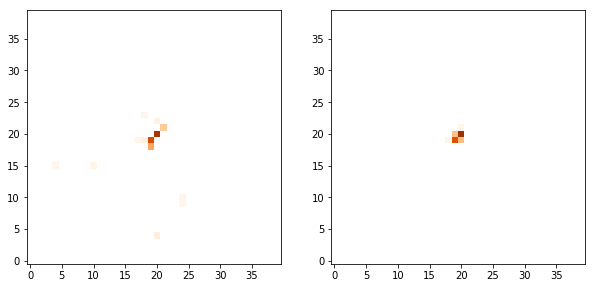

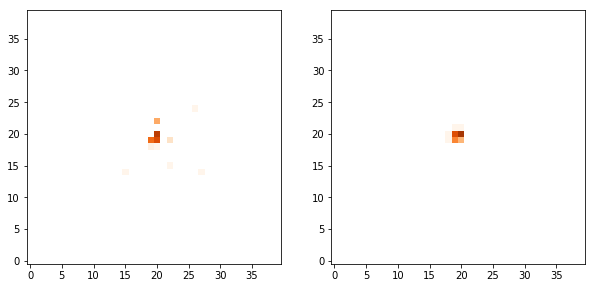

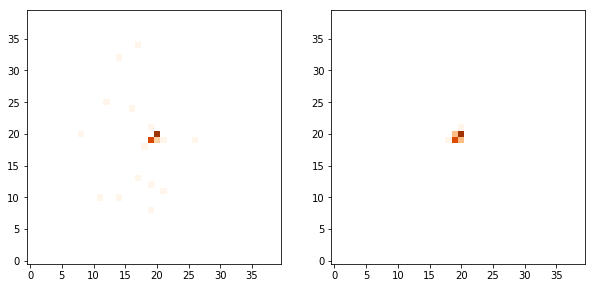

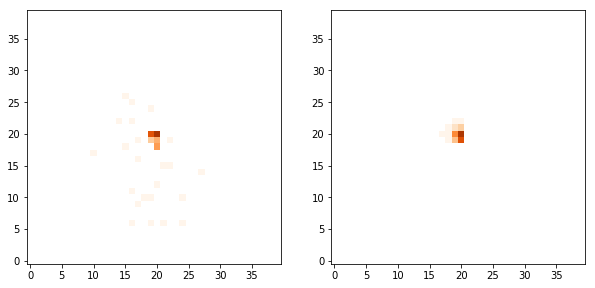

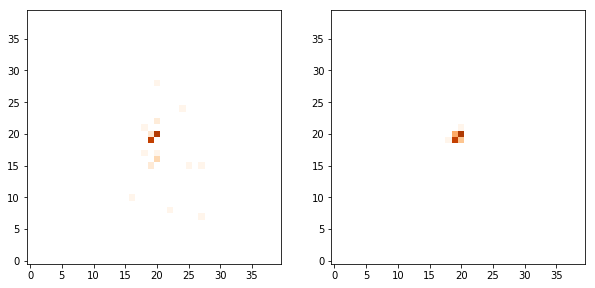

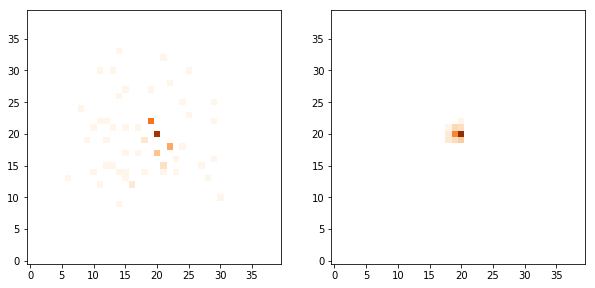

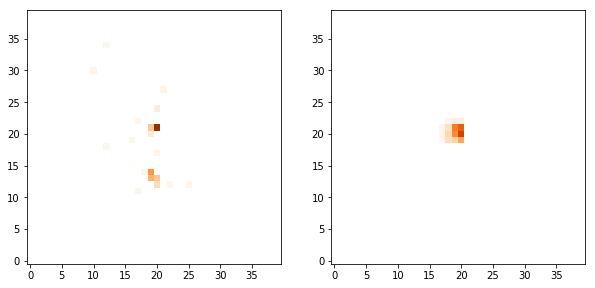

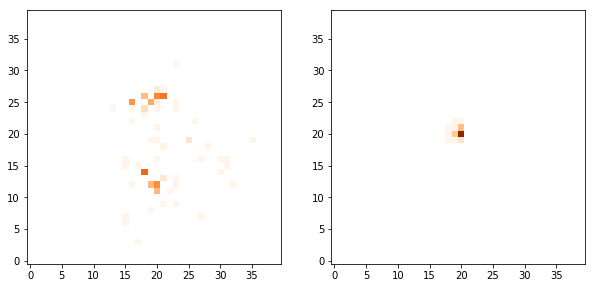

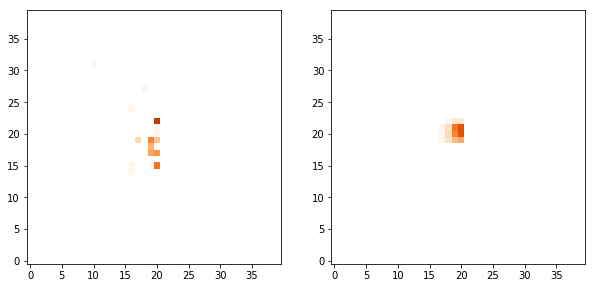

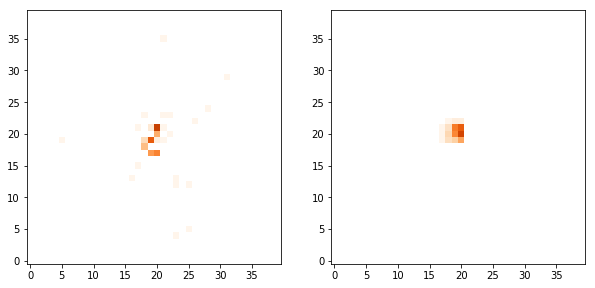

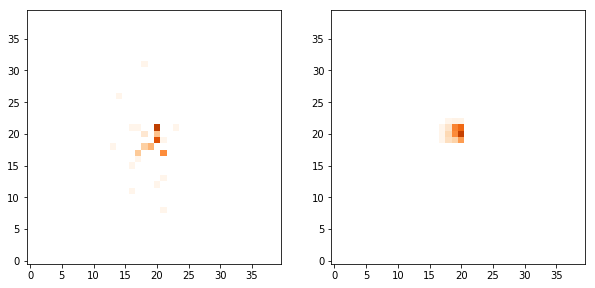

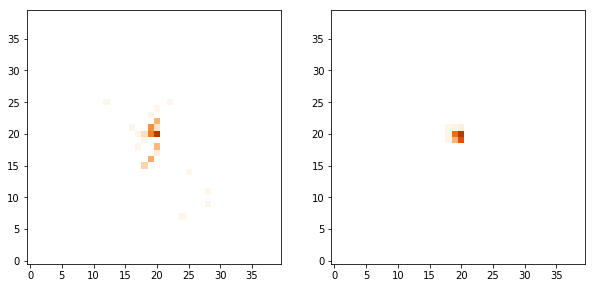

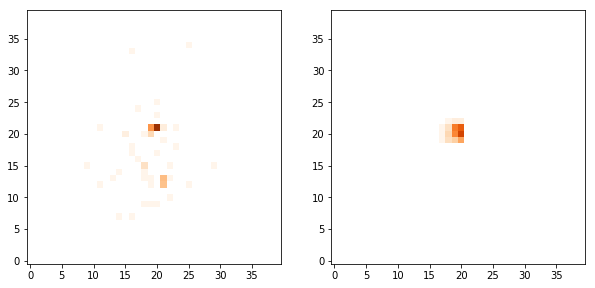

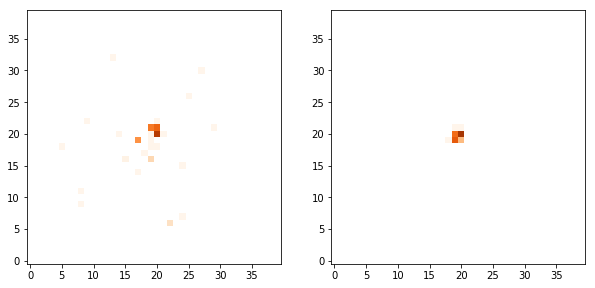

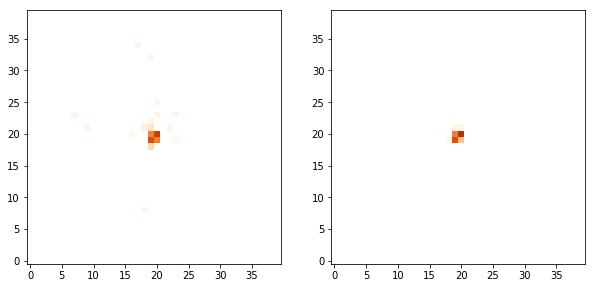

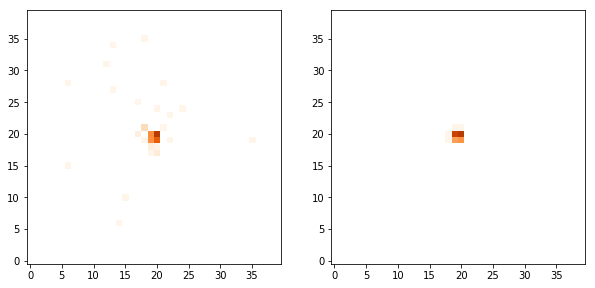

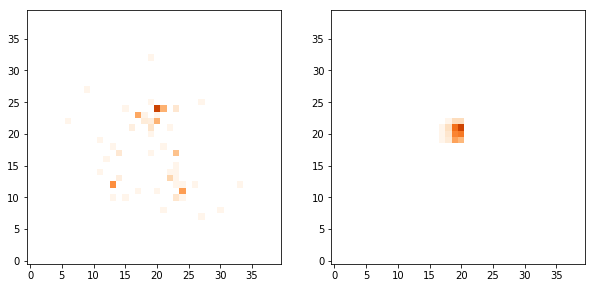

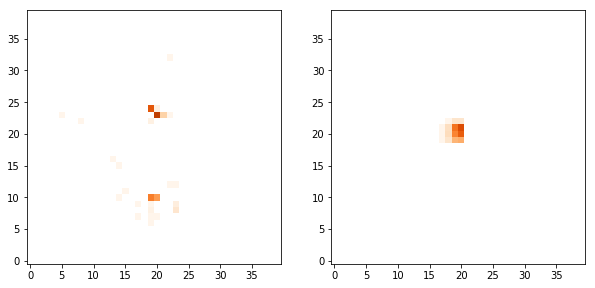

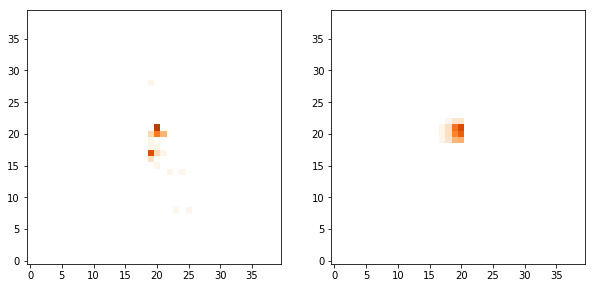

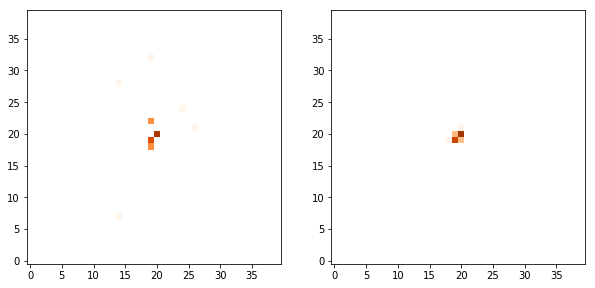

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

for i in range(20):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    ax[0].imshow(valid_data[i,:,:,0].T, norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    ax[1].imshow(chop(vae.predict(valid_data[i:i+1].T)[0,:,:,0].T,chop=1e-3), norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    plt.show()

### Top reconstructions

In [18]:
data_dir = "/data1/users/jcollins/Heidelberg_sample"
hdfstore = pd.HDFStore("/data1/users/jcollins/Heidelberg_sample/train_images_top.h5")
# train_data = hdfstore.select("points",stop=numjets).values
# train_data = train_data.reshape(numjets,pixels,pixels,1)

valid_data_top = hdfstore.select("points",start=numjets,stop=numjets+numvalid).values
valid_data_top = valid_data_top.reshape(numvalid,pixels,pixels,1)

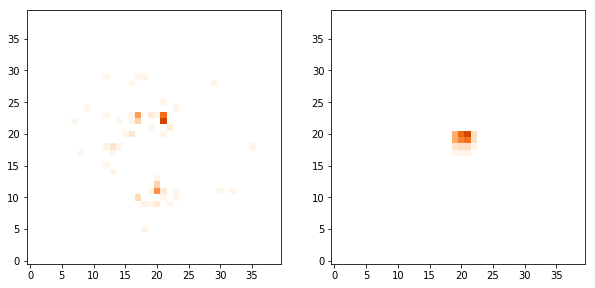

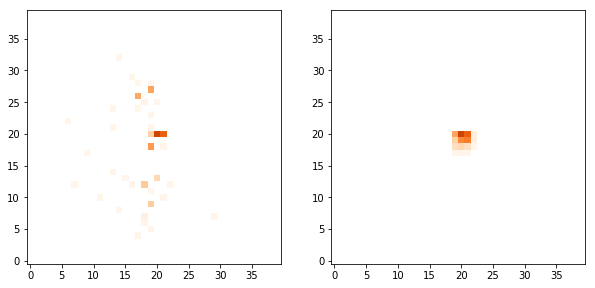

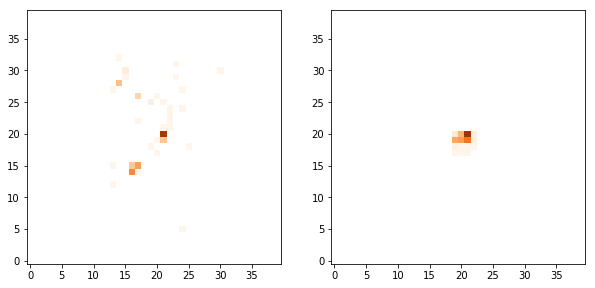

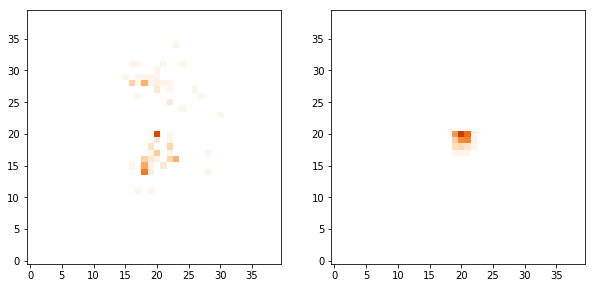

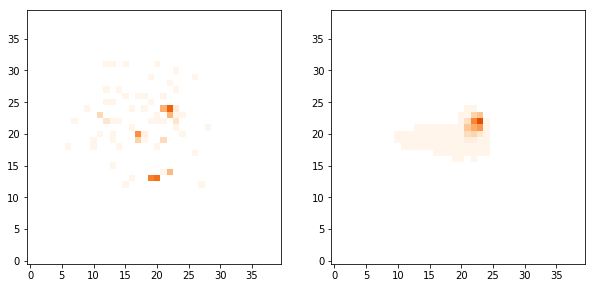

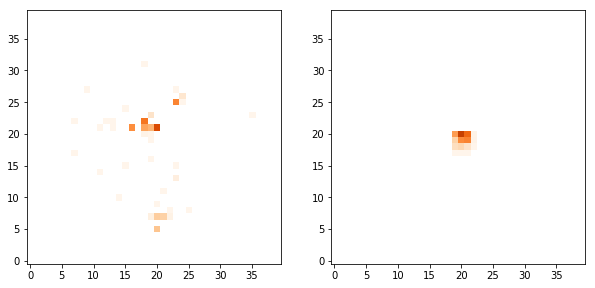

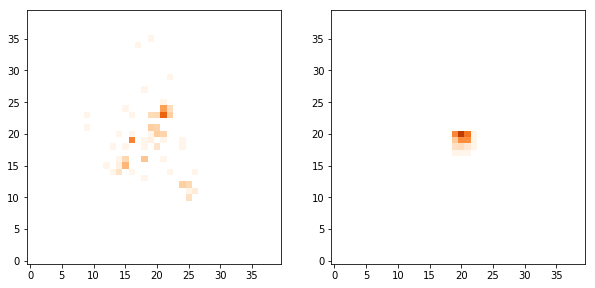

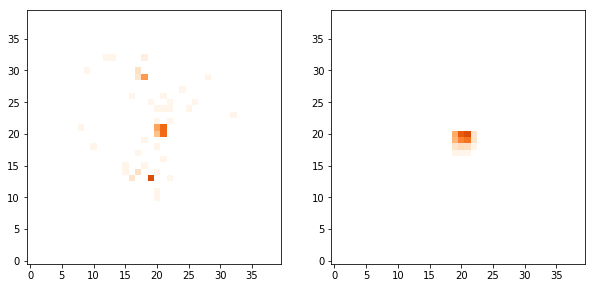

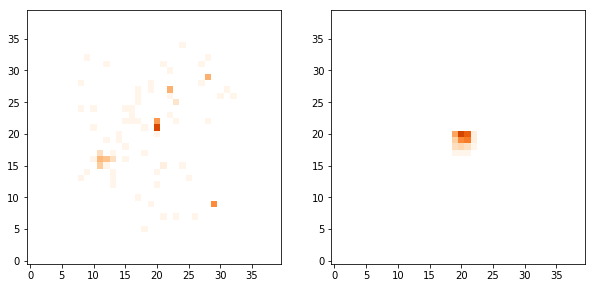

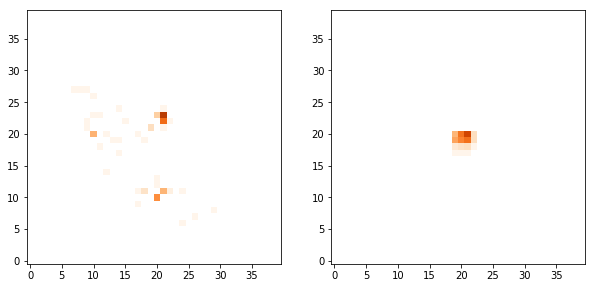

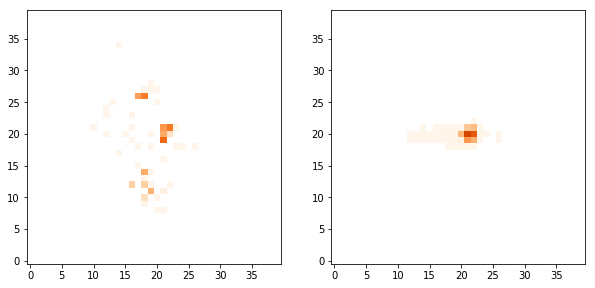

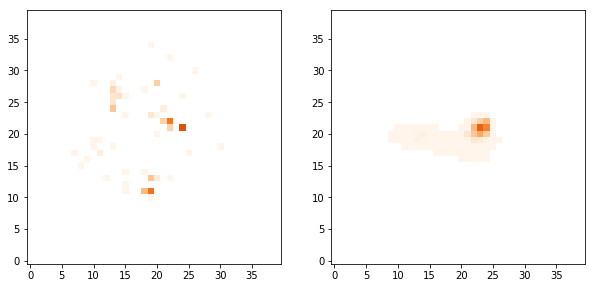

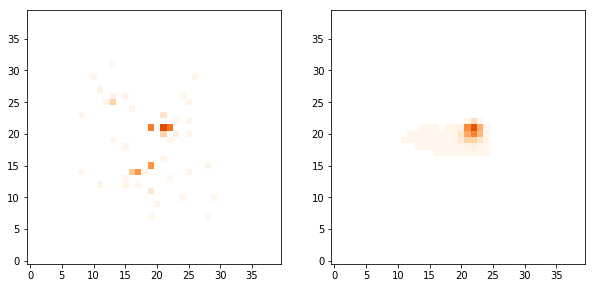

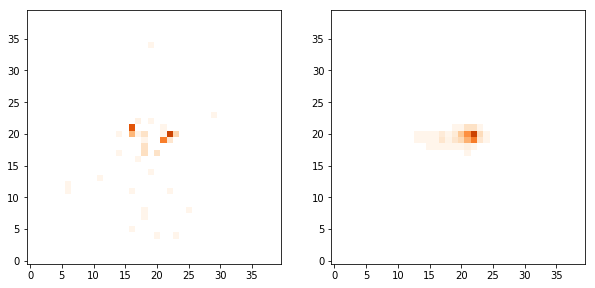

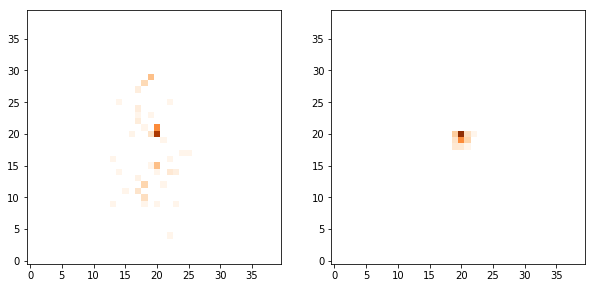

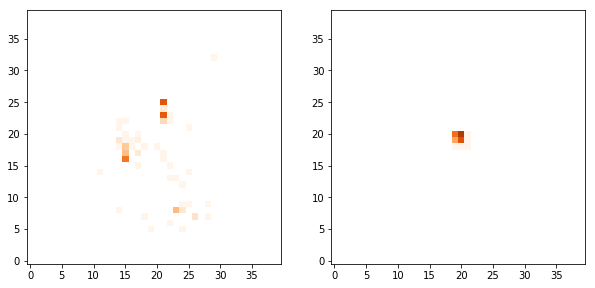

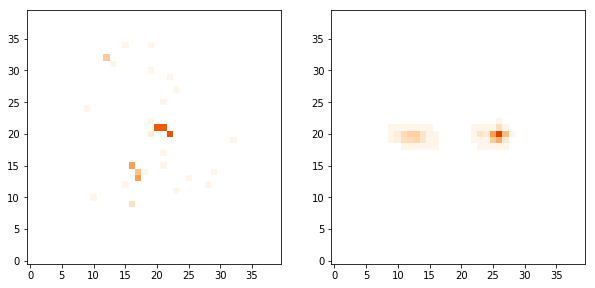

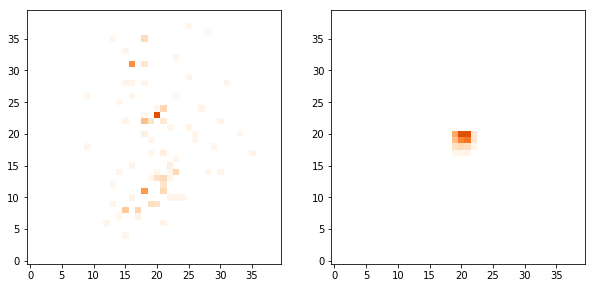

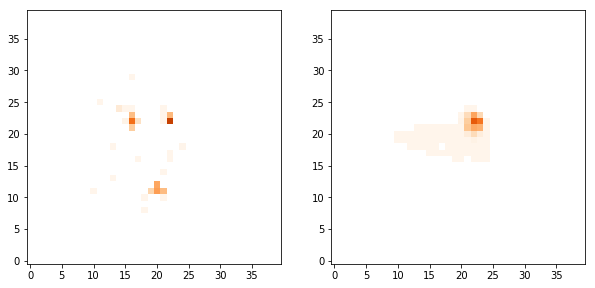

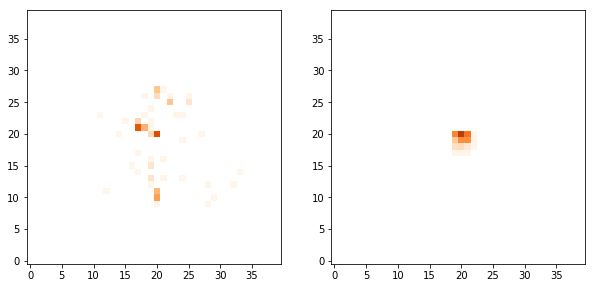

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

for i in range(20):
    fig, ax = plt.subplots(1, 2,figsize=[10,5])
    ax[0].imshow(valid_data_top[i,:,:,0].T, norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    ax[1].imshow(chop(vae.predict(valid_data_top[i:i+1].T)[0,:,:,0],chop=1e-3), norm=LogNorm(0.01, 1),
               origin='lower',cmap='Oranges')
    plt.show()

### 1D latent space visualization

Let's first look at the distribution of latent codes

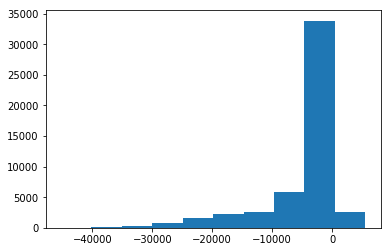

In [23]:
latent_codes = encoder.predict(valid_data)
plt.hist(latent_codes.flatten())
plt.show()

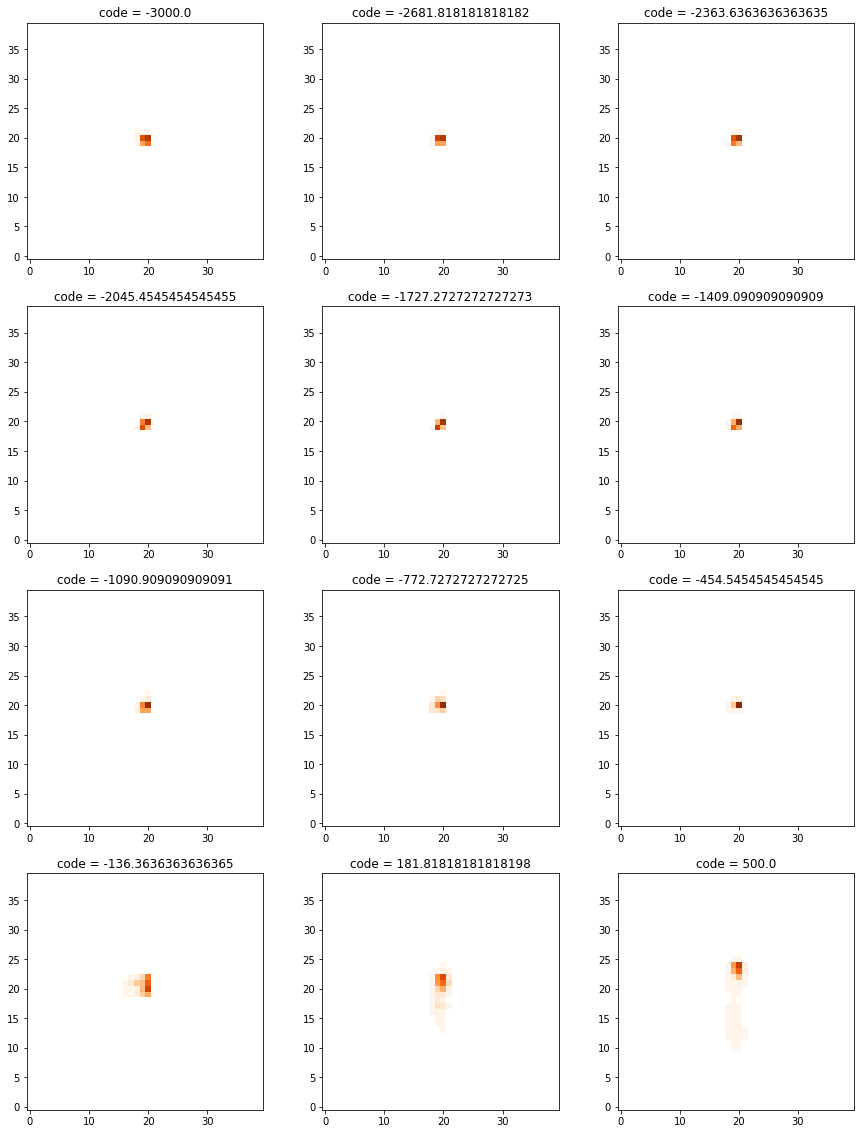

In [24]:
lim=0.8
bins=np.linspace(-lim, lim, 50)
#codes = np.array([0.45,0.7,1])
codes = np.linspace(-3000,500,12)
reconstructions=decoder.predict(codes)

plt.figure(figsize=[15,20])

for i, reconstruction in enumerate(reconstructions):
    plt.subplot(4,3,i+1)
    #counts, bx, by = np.histogram2d(reconstruction[:,0],reconstruction[:,1],bins=bins)
    #print codes[i]
    plt.imshow(chop(reconstruction[:,:,0].T,chop=1e-3), norm=LogNorm(0.01, 1), origin='lower',cmap='Oranges')
    plt.title("code = " + str(codes[i]))
plt.show()